In [1]:
# %env PYTORCH_ENABLE_MPS_FALLBACK=1
%load_ext autoreload
%autoreload

from bins import Bins
from eventsreader import Frame
from hist_utils import HistMaker, HistMaker1d, geom_avg1d, symmetrize
from hist_template import set_opt_text, set_th1, set_pad
import helicity_model_1d
import helicity_model_3d
from plotting import plot_losses, show_results, paveTexts
from ROOT import TH1, TF1, TCanvas, gStyle, TLegend
import calendar, os
from time import gmtime

Welcome to JupyROOT 6.28/04


In [2]:
gStyle.SetOptStat(0)

analyse_3d = True
learn_norm = False
same_sign_symm = False
ag1580ag = True
event_mixing = False
symmetrize_explicit = False
read_saved = False
range_used = range(0,12)
fraction = 0.8

if read_saved:
    if event_mixing:
        if ag1580ag:
            DIR_NAME = "results_mixing_nu15_noise1em1_1d_ag1580ag"
        else:
            DIR_NAME = "results_mixing_nu15_noise1em1_1d"
    else:
        if ag1580ag:
           # DIR_NAME = "results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr"
           # DIR_NAME = "results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr"
           # DIR_NAME = "results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr_vertexsim_epem"
            DIR_NAME = "results_1702372287"
        else:
            DIR_NAME = "results_sameevt_nu15_noise1em1_1d"
else:
    current_GMT =   gmtime()
    time_stamp = calendar.timegm(current_GMT)
    DIR_NAME = f'results_{time_stamp}'
    os.mkdir(DIR_NAME)

In [3]:
from hist_utils import CombinedHistMaker

if ag1580ag:
    ekin = 1580
    filename_data_np = "063_088_ag158ag_3200A_accepted_np.dat"
   # filename_data_np = "mar19_diele_inmedium_helip1cm_ag1580ag_np.dat"
   # filename_data_np = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_data_pp = "063_088_ag158ag_3200A_accepted_pp.dat"
    filename_data_nn = "063_088_ag158ag_3200A_accepted_nn.dat"
    filename_data_np_mix = "063_088_ag158ag_3200A_accepted_np_mix_hc.dat"
    filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc.dat"
    filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc.dat"
    filename_MC_rho_4pi_heli0 = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_2_np_kine.dat"
    filename_MC_rho_4pi_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_2_np_kine.dat"
   # filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1580ag_np.dat"
   # filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_np.dat"
   # filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp.dat"
   # filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn.dat"
    filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_np_newCuts.dat"
    filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp_newCuts.dat"
    filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn_newCuts.dat"
    filename_MC_rho_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_jver22_np.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_ag1580ag_np_mix.dat"
    if same_sign_symm:
        filename_data_pp = "063_088_ag158ag_3200A_accepted_pp_symm.dat"
        filename_data_nn = "063_088_ag158ag_3200A_accepted_nn_symm.dat"
       # filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc_symm.dat"
       # filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc_symm.dat"
       # filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp_swapRandomly.dat"
       # filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn_swapRandomly.dat"
else:
    ekin = 1230
    filename_data_np = "apr12_diele_088_090_ag123ag_2500A_accepted_np_2.dat"
    filename_data_pp = "088_090_ag123ag_2500A_accepted_pp.dat"
    filename_data_nn = "088_090_ag123ag_2500A_accepted_nn.dat"
    filename_data_np_mix = "apr12_diele_089_ag123ag_2500A_accepted_93_np_mix_hc.dat"
    filename_data_pp_mix = "088_090_ag123ag_2500A_accepted_pp_mix_hc.dat"
    filename_data_nn_mix = "088_090_ag123ag_2500A_accepted_nn_mix_hc.dat"
    filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1230ag_jver22_np.dat"
    filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1230ag_jver22_pp.dat"
    filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1230ag_jver22_nn.dat"
    filename_MC_rho_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_np.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_np_mix.dat"


frame = Frame.HX

HistMakerClass = HistMaker if analyse_3d else HistMaker1d

bins = Bins.readFrom("ranges.yml")
#histMakerData_np = HistMakerClass("apr12_diele_088_090_ag123ag_2500A_accepted_np_mix_hc_sample_2.dat", "_data", bins, frame)
if event_mixing:
    histMakerData_np = HistMakerClass(filename_data_np_mix, "_data_np", bins, frame, ekin)
else:
    histMakerData_np = HistMakerClass(filename_data_np, "_data_np", bins, frame, ekin)
histsData_np = histMakerData_np.make_hists  ()
histMakerData_pp = HistMakerClass(filename_data_pp, "_data_pp", bins, frame, ekin)
histsData_pp = histMakerData_pp.make_hists()
histMakerData_nn = HistMakerClass(filename_data_nn, "_data_nn", bins, frame, ekin)
histsData_nn = histMakerData_nn.make_hists()

histMakerData_np_mix = HistMakerClass(filename_data_np_mix, "_data_np_mix", bins, frame, ekin)
histsData_np_mix = histMakerData_np_mix.make_hists()
histMakerData_pp_mix = HistMakerClass(filename_data_np_mix, "_data_pp_mix", bins, frame, ekin)
histsData_pp_mix = histMakerData_pp_mix.make_hists()
histMakerData_nn_mix = HistMakerClass(filename_data_nn_mix, "_data_nn_mix", bins, frame, ekin)
histsData_nn_mix = histMakerData_nn_mix.make_hists()

histMakerMC_rho_heli0_np = HistMakerClass(filename_MC_rho_heli0_np, "_MC_rho_heli0", bins, frame, ekin)
histMakerMC_rho_heli0_pp = HistMakerClass(filename_MC_rho_heli0_pp, "_MC_rho_heli0_pp", bins, frame, ekin)
histMakerMC_rho_heli0_nn = HistMakerClass(filename_MC_rho_heli0_nn, "_MC_rho_heli0_nn", bins, frame, ekin)
histMakerMC_rho_heli1 = HistMakerClass(filename_MC_rho_heli1, "_MC_rho_heli1", bins, frame, ekin)
histMakerMC_pi0 = HistMakerClass(filename_MC_pi0, "_MC_pi0", bins, frame, ekin)
histMakerMC_mix = HistMakerClass(filename_MC_mix, "_MC_mix", bins, frame, ekin)
#histMakerMC_mix = HistMakerClass("test_inmedium_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
#histMakerMC_mix = HistMakerClass("mar19_diele_pi0_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
def get_hist_maker_mc(sign, hist_index):
    if event_mixing:
        return histMakerMC_mix
    else:
        if hist_index < 3:
            return CombinedHistMaker(histMakerMC_pi0, histMakerMC_rho_heli0_np, fraction)
        else:
            if sign == "np":
                return histMakerMC_rho_heli0_np
            elif sign == "pp":
                return histMakerMC_rho_heli0_pp
            else:
                return histMakerMC_rho_heli0_nn
        # return histMakerMC_rho_heli0_np

Pickle file exists
[12/31/2023, 19:48:24]: iter  0
[12/31/2023, 19:48:24] Before processing events
Num events 411996
Num non-null events 411996
[12/31/2023, 19:48:25] After processing events
#1 result length 4
Pickle file exists
[12/31/2023, 19:48:25]: iter  1
[12/31/2023, 19:48:25] Before processing events
Num events 88408
Num non-null events 88408
[12/31/2023, 19:48:25] After processing events
#1 result length 4
Pickle file exists
[12/31/2023, 19:48:26]: iter  2
[12/31/2023, 19:48:26] Before processing events
Num events 143998
Num non-null events 143998
[12/31/2023, 19:48:27] After processing events
#1 result length 4
Pickle file exists
[12/31/2023, 19:48:32]: iter  3
[12/31/2023, 19:48:32] Before processing events
Num events 1146500
Num non-null events 1146500
[12/31/2023, 19:48:35] After processing events
#1 result length 4
Pickle file exists
[12/31/2023, 19:48:40]: iter  4
[12/31/2023, 19:48:40] Before processing events
Num events 1146500
Num non-null events 1146500
[12/31/2023, 1

In [4]:
import torch

torch.device("mps")
torch.manual_seed(0)

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [5]:
TH1.SetDefaultSumw2()

In [6]:
torch.backends.mps.is_available()
#mps_device = torch.device("mps")
mps_device = torch.device("cpu")
bounds = torch.tensor([[-2, ],
                       [ 2, ]], dtype=torch.float)
bounds = bounds.to(mps_device)


xs = torch.linspace(bounds[0][0], bounds[1][0], 101)

In [7]:
parameters_all_np = []
losses_all_np = [[]]* len(range_used)

fit_simple = helicity_model_3d.fit_simple if analyse_3d else helicity_model_1d.fit_simple

for HIST_INDEX in range_used:
    simple_model = helicity_model_3d.Helicity3d(learn_norm) if analyse_3d else helicity_model_1d.Helicity1d(learn_norm)
    hist_data_simple = histsData_np[0][HIST_INDEX]
    hist_mc_simple = get_hist_maker_mc("np", HIST_INDEX).make_hists(0.0)[0][HIST_INDEX]
    if HIST_INDEX == 2:
        losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 1000, 0.01, learn_norm)
    else:
        losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 1000, 0.01, learn_norm)
    parameters_all_np.append([param for param in simple_model.parameters()])
    losses_all_np[HIST_INDEX] = losses
    
parameters_all_pp = []
losses_all_pp = [[]]* len(range_used)

for HIST_INDEX in range_used:
    simple_model = helicity_model_3d.Helicity3d(learn_norm) if analyse_3d else helicity_model_1d.Helicity1d(learn_norm)
    hist_data_simple = histsData_pp[0][HIST_INDEX]
    hist_mc_simple = get_hist_maker_mc("pp", HIST_INDEX).make_hists(0.0)[0][HIST_INDEX]
    losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 10000, 0.01, learn_norm)
    parameters_all_pp.append([param for param in simple_model.parameters()])
    losses_all_pp[HIST_INDEX] = losses
    
parameters_all_nn = []
losses_all_nn = [[]]* len(range_used)

for HIST_INDEX in range_used:
    simple_model = helicity_model_3d.Helicity3d(learn_norm) if analyse_3d else helicity_model_1d.Helicity1d(learn_norm)
    hist_data_simple = histsData_nn[0][HIST_INDEX]
    hist_mc_simple = get_hist_maker_mc("nn", HIST_INDEX).make_hists(0.0)[0][HIST_INDEX]
    losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 10000, 0.01, learn_norm)
    parameters_all_nn.append([param for param in simple_model.parameters()])
    losses_all_nn[HIST_INDEX] = losses

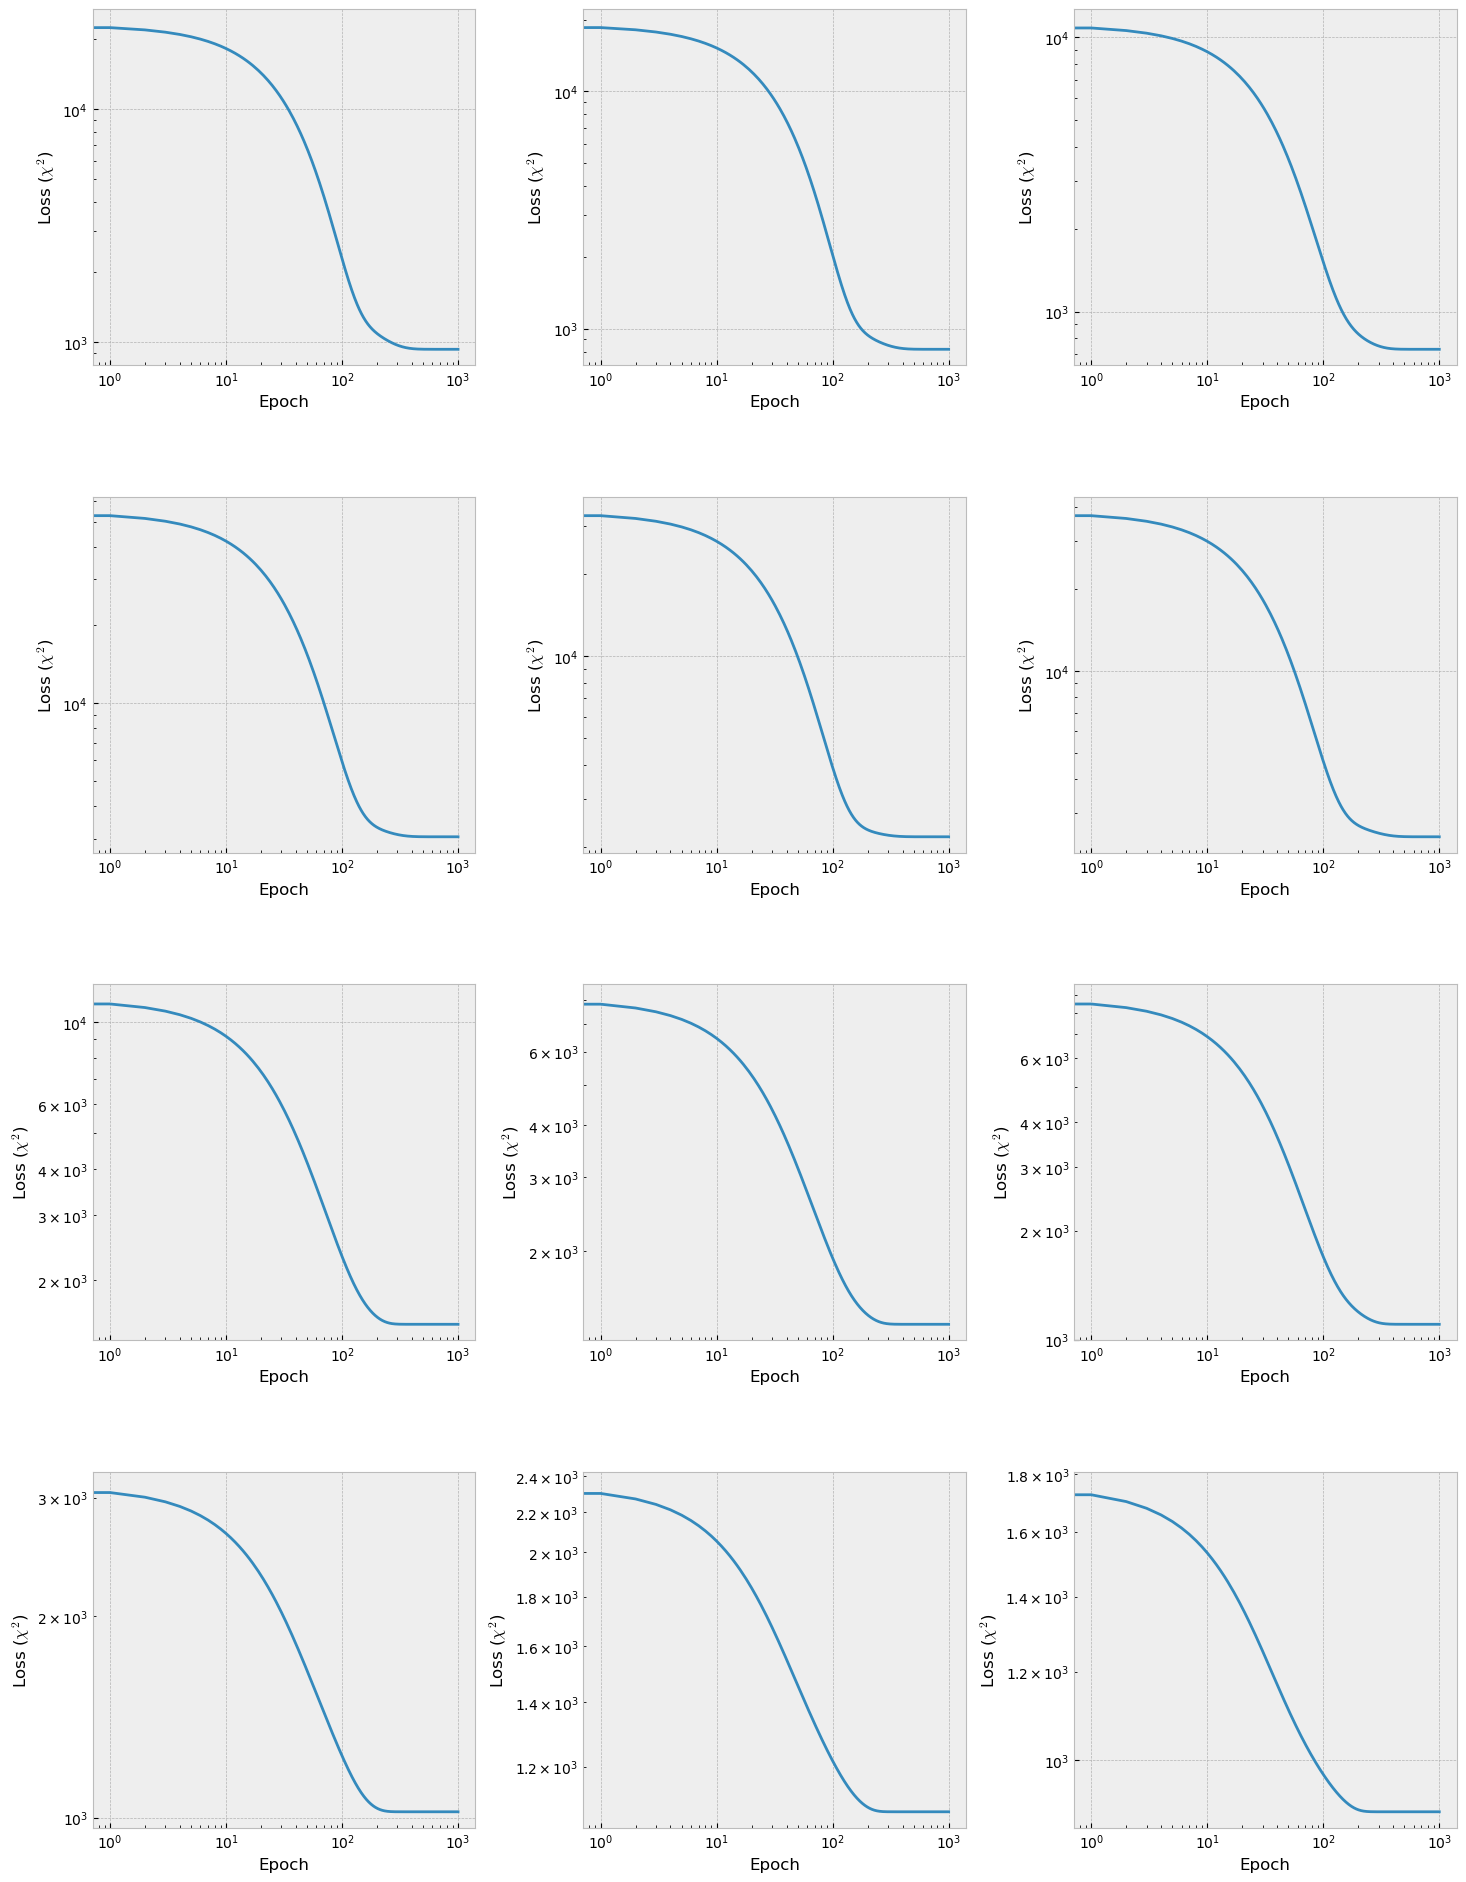

In [8]:
fig_np, ax_np = plot_losses(losses_all_np, range_used)

# Calculating covariance matrix for parameters

In general, if the value of the fitted model with $m$ parameters at point $x_i$ can be expressed as:
$$f(x_i,\mathbf{\lambda})=\sum_{j=1}^{m}a_j(x_i)\lambda_j\equiv\sum_{j=1}^{m}A_{ij}\lambda_j,$$
then the expression for $\chi^2$ is:
$$\chi^2=(\mathbf{y}-A\mathbf{\lambda})^T V^{-1}(\mathbf{y}-A\mathbf{\lambda}),$$
where $V$ is the covariance matrix of different data points. We have only statistical errors at each data point (histogram bin in our case), so we assume, witn $n$ data points (bins),
$$V^{-1}=\mathrm{diag}\left(\frac{1}{\sigma^2_{1}},\frac{1}{\sigma^2_{2}},\frac{1}{\sigma^2_{3}},...,\frac{1}{\sigma^2_{n}}\right).$$
The covariance matrix for for parameters, $U=\mathrm{cov}[\hat{\lambda}_i,\hat{\lambda}_j]$ is calculated as
$$U=(A^TV^{-1}A)^{-1}.$$
In our case, the $i$-th row of matrix $A$, corresponding to the $i$-th data point (bin) has the following form:
$$\left(\frac{c_i}{I}\;\;\;\frac{c_i}{I}\cos^2(\theta_i)\;\;\;\frac{c_i}{I}\sin(2\theta_i)cos(\phi_i)\;\;\;\frac{c_i}{I}\sin^2(\theta_i)\cos(2\phi_i)\right),$$
where $\theta_i$, $\phi_i$ are values corresponding the bin center. Note, that one of the axes is $\cos(\theta)$, so $\arccos$ has to be calculated. $c_i$ is the bin content of the **unweighted** model histogram. $I$ is the integral of the model histogram **after applying the weights**. Thanks to that, the weighted histogram is always normalized to unity and can be compared to the experimental data histogram ($\mathbf{y}$) which is also normalized to unity all the time.

For the errors of the fit parameters, we just use square roots of the diagonal elements of the matrix $U$. However, with the matrix $A$ given above, we calculate the covariance matrix for the fit:
$$f(\theta,\phi)=A+B\cos^2(\theta_i)+C\sin(2\theta_i)cos(\phi_i)+D\sin^2(\theta_i)\cos(2\phi_i).$$
In order to get correct errors of the parameters of the fit:
$$f(\theta,\phi)\propto1+\lambda_\theta\cos^2(\theta_i)+\lambda_{\theta\phi}\sin(2\theta_i)cos(\phi_i)+\lambda_\phi\sin^2(\theta_i)\cos(2\phi_i),$$
we use error propagation to calculate the errors of ratios of ${B, C, D}$ parameters to $A$.

Maybe covariance matrix:
tensor([[ 3.8894e-05, -2.0107e-04,  2.3754e-06,  5.0689e-06],
        [-2.0107e-04,  2.8519e-03,  1.5250e-04, -1.0692e-06],
        [ 2.3754e-06,  1.5250e-04,  2.2274e-04,  2.2191e-05],
        [ 5.0689e-06, -1.0692e-06,  2.2191e-05,  5.9704e-05]])
Compare:
Old: 0.11794519553863363, new: 0.05344675948618556, new/old: 0.4531491023615181
Old: 0.04222791235133246, new: 0.014925916537009493, new/old: 0.35346091497081833
Old: 0.03631746282522461, new: 0.00772738204667418, new/old: 0.21277317977474625
0. Final result: lambda_theta = 0.3467 +- 0.0534, lambda_phi = 0.0148 +- 0.0077, lambda_theta_phi = 0.0341 +- 0.0149
Maybe covariance matrix:
tensor([[ 4.6291e-05, -2.4592e-04,  8.2442e-07,  3.0153e-06],
        [-2.4592e-04,  3.4992e-03,  1.6671e-04, -2.5702e-05],
        [ 8.2442e-07,  1.6671e-04,  2.5741e-04,  1.4364e-05],
        [ 3.0153e-06, -2.5702e-05,  1.4364e-05,  6.5289e-05]])
Compare:
Old: 0.15459766038690834, new: 0.05926460101783997, new/old: 0.38334733442

Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_0
Info in <TCanvas::Print>: gif file results_1704048502/comparison_2.gif has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_3
Info in <TCanvas::Print>: gif file results_1704048502/comparison_5.gif has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_6
Info in <TCanvas::Print>: gif file results_1704048502/comparison_8.gif has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_9
Info in <TCanvas::Print>: gif file results_1704048502/comparison_11.gif has been created


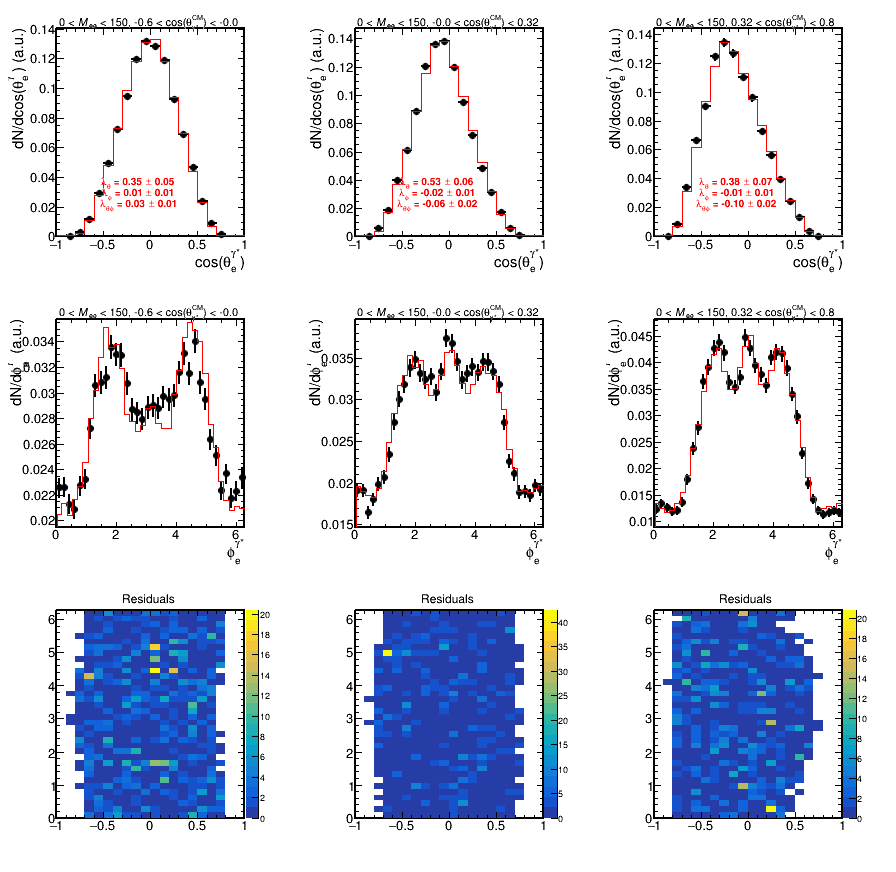

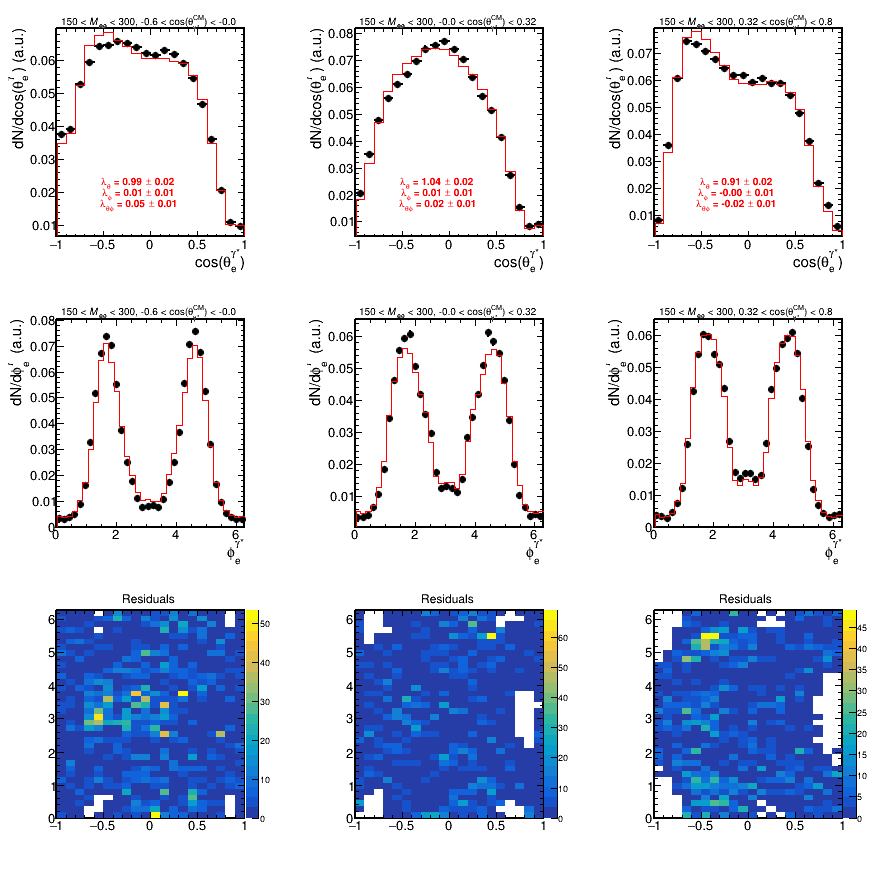

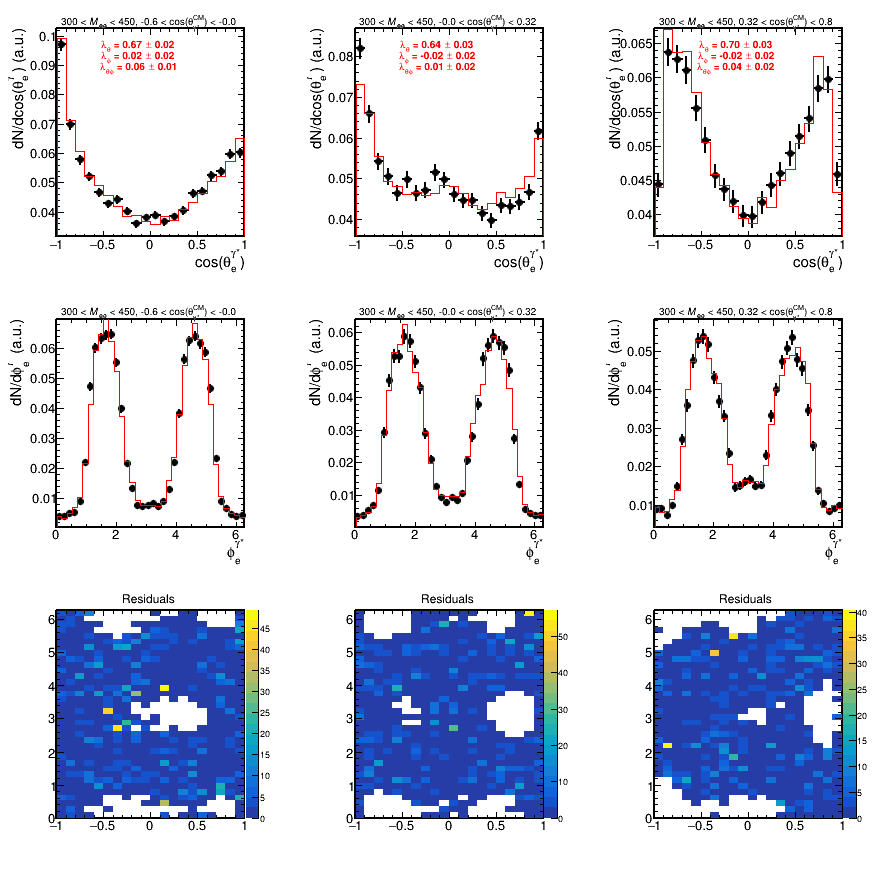

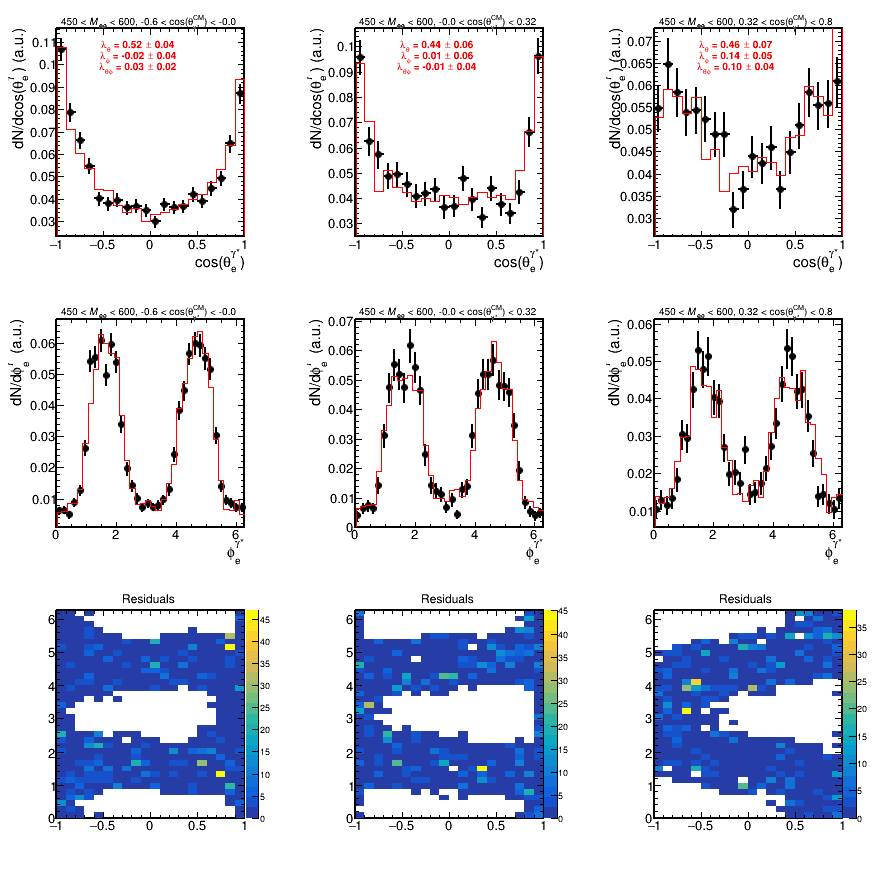

In [9]:
show_results("np", DIR_NAME, range_used, parameters_all_np, get_hist_maker_mc, bins, histsData_np, analyse_3d)

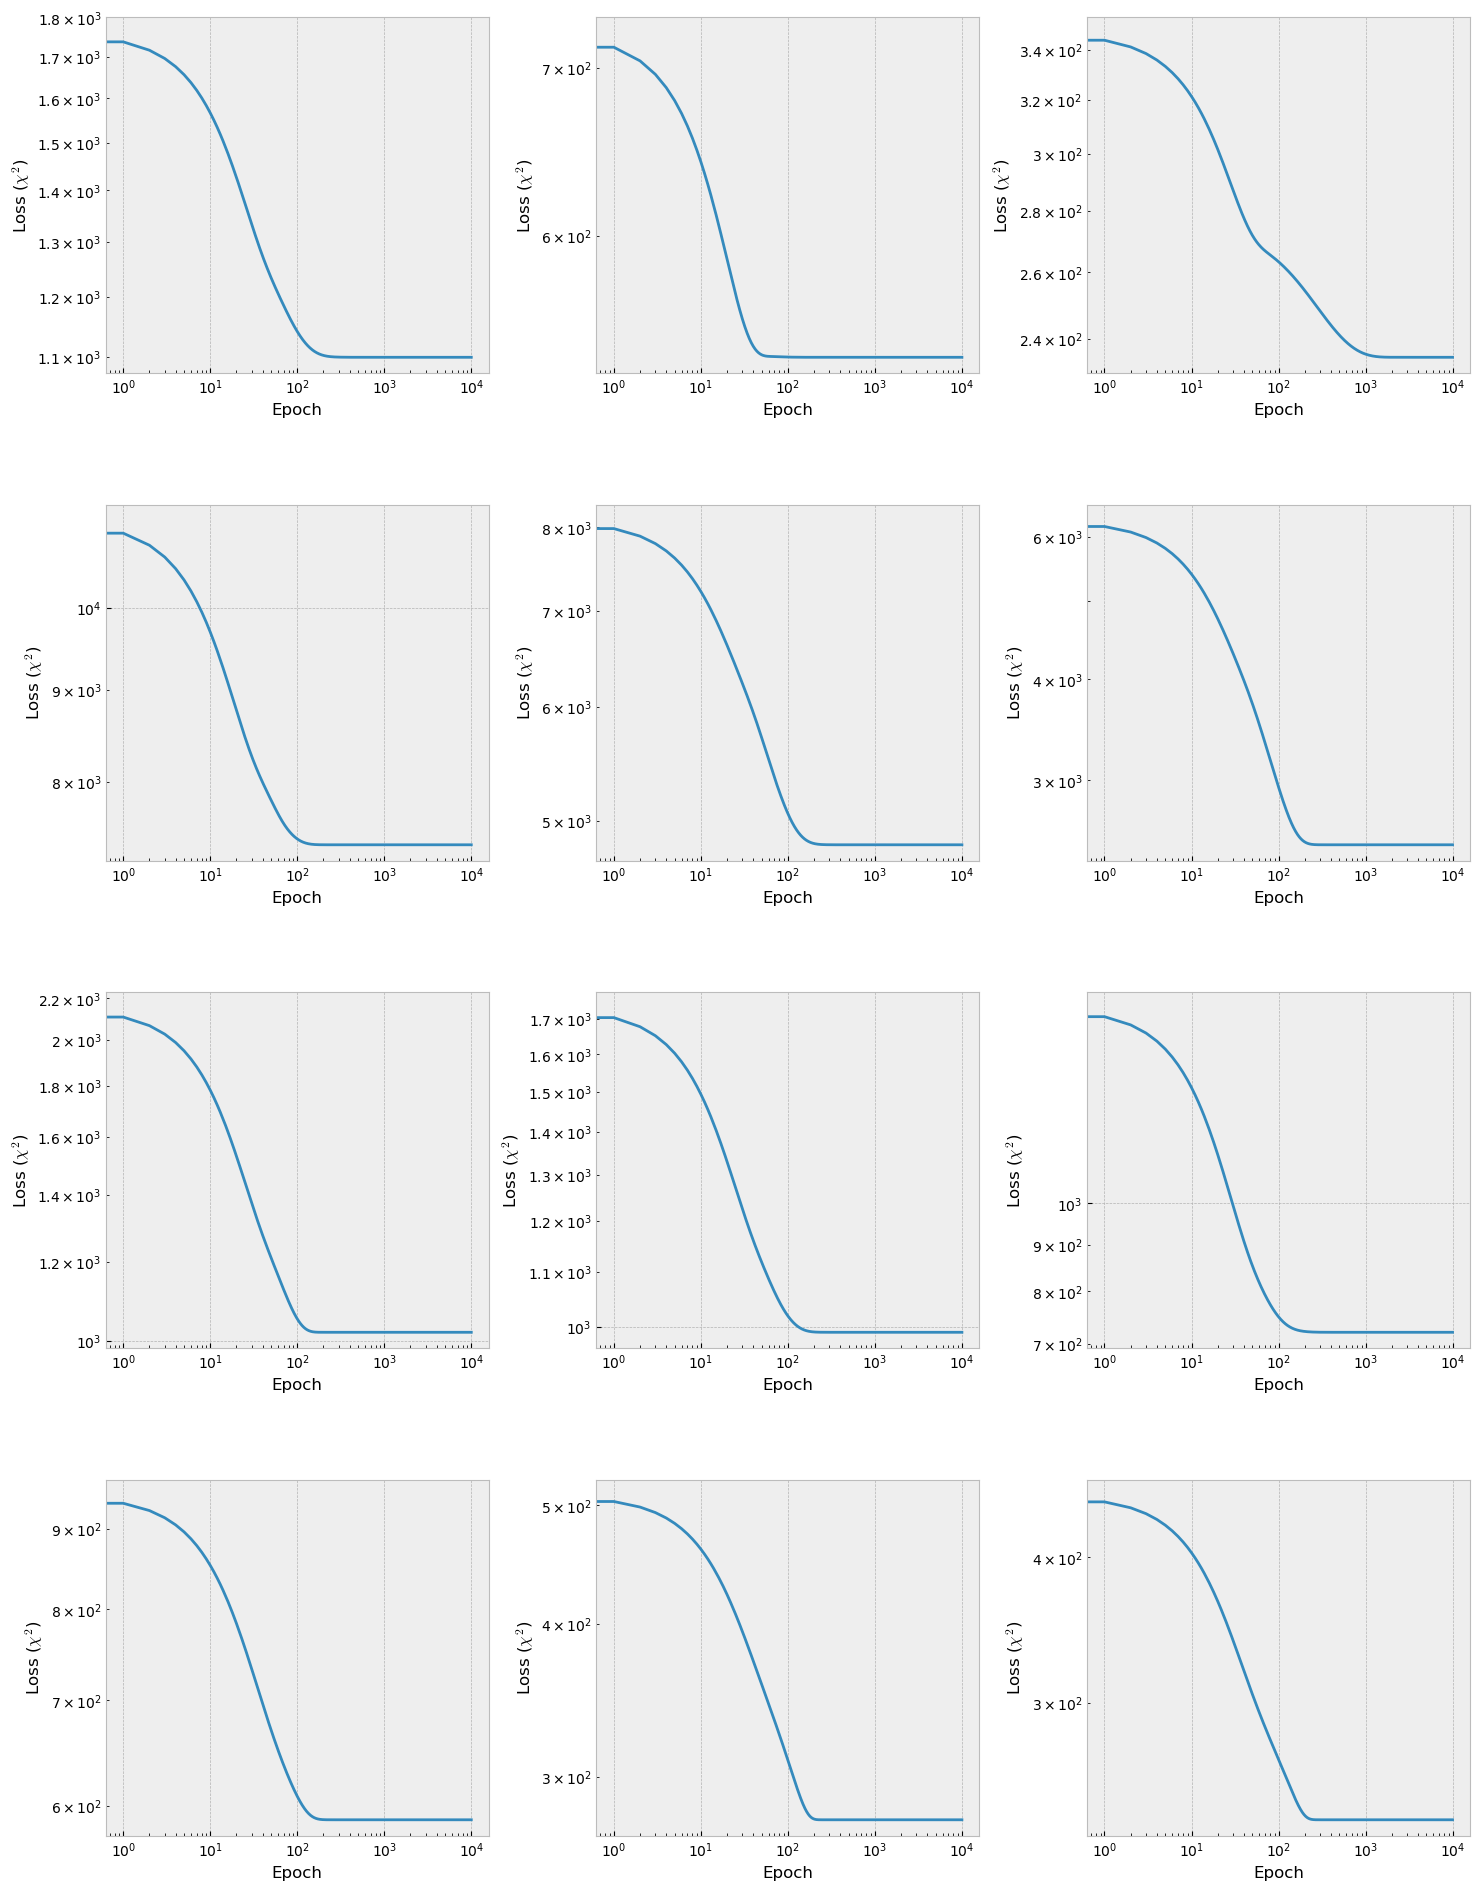

In [10]:
fig_pp, ax_pp = plot_losses(losses_all_pp, range_used)

Maybe covariance matrix:
tensor([[ 4.6222e-04, -2.9114e-03,  4.4150e-05,  1.9698e-04],
        [-2.9114e-03,  5.0953e-02,  2.8724e-03, -9.9338e-04],
        [ 4.4150e-05,  2.8724e-03,  3.8661e-03,  2.0728e-04],
        [ 1.9698e-04, -9.9339e-04,  2.0728e-04,  6.2356e-04]])
Compare:
Old: 0.3255763460157749, new: 0.2276959708650019, new/old: 0.6993627566972249
Old: 0.10322597455965085, new: 0.06234368312870426, new/old: 0.6039534467429796
Old: 0.07337765832066451, new: 0.028509401454120866, new/old: 0.388529725622112
0. Final result: lambda_theta = 1.3892 +- 0.2277, lambda_phi = 0.6398 +- 0.0285, lambda_theta_phi = -0.2111 +- 0.0623
Maybe covariance matrix:
tensor([[ 7.9590e-04, -5.4460e-03,  1.9513e-04, -4.1863e-05],
        [-5.4460e-03,  1.1234e-01,  1.0023e-02, -1.2178e-03],
        [ 1.9513e-04,  1.0023e-02,  7.0077e-03,  7.1683e-04],
        [-4.1864e-05, -1.2178e-03,  7.1683e-04,  1.0948e-03]])
Compare:
Old: 0.3170222607597341, new: 0.33669136814460887, new/old: 1.0620433004853929

Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_0
Info in <TCanvas::Print>: gif file results_1704048502/comparison_2.gif has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_3
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_3
Info in <TCanvas::Print>: gif file results_1704048502/comparison_5.gif has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_6
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_6
Info in <TCanvas::Print>: gif file results_1704048502/comparison_8.gif has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_9
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_9
Info in <TCanvas::Print>: gif file results_1704048502/comparison_11.gif has been created


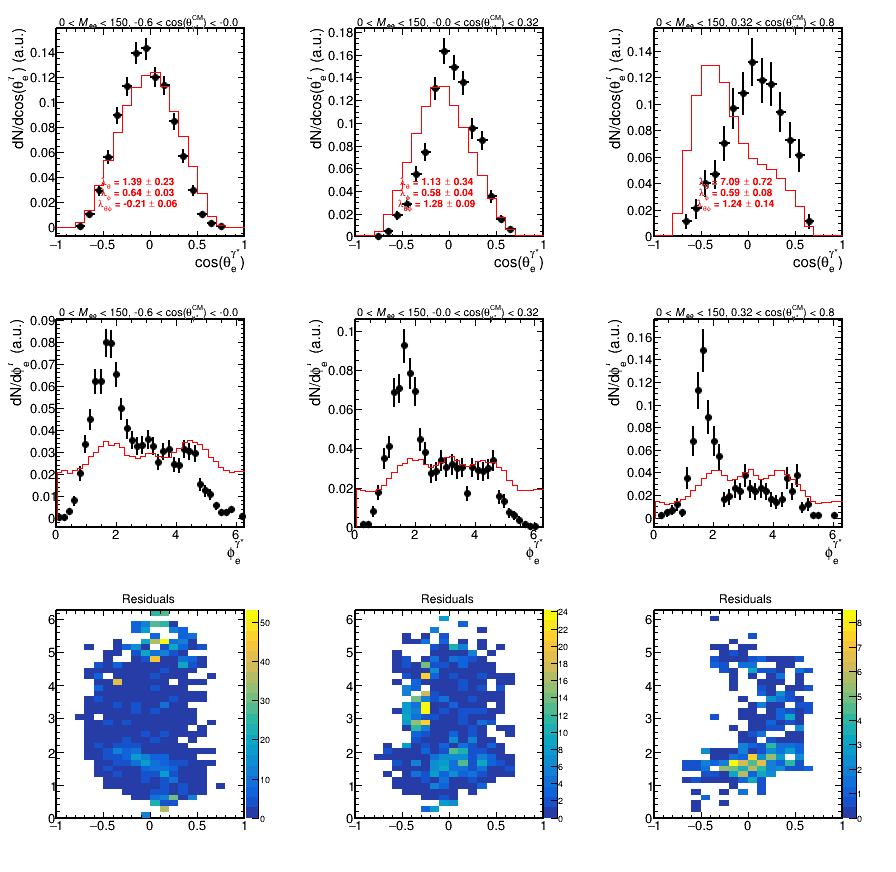

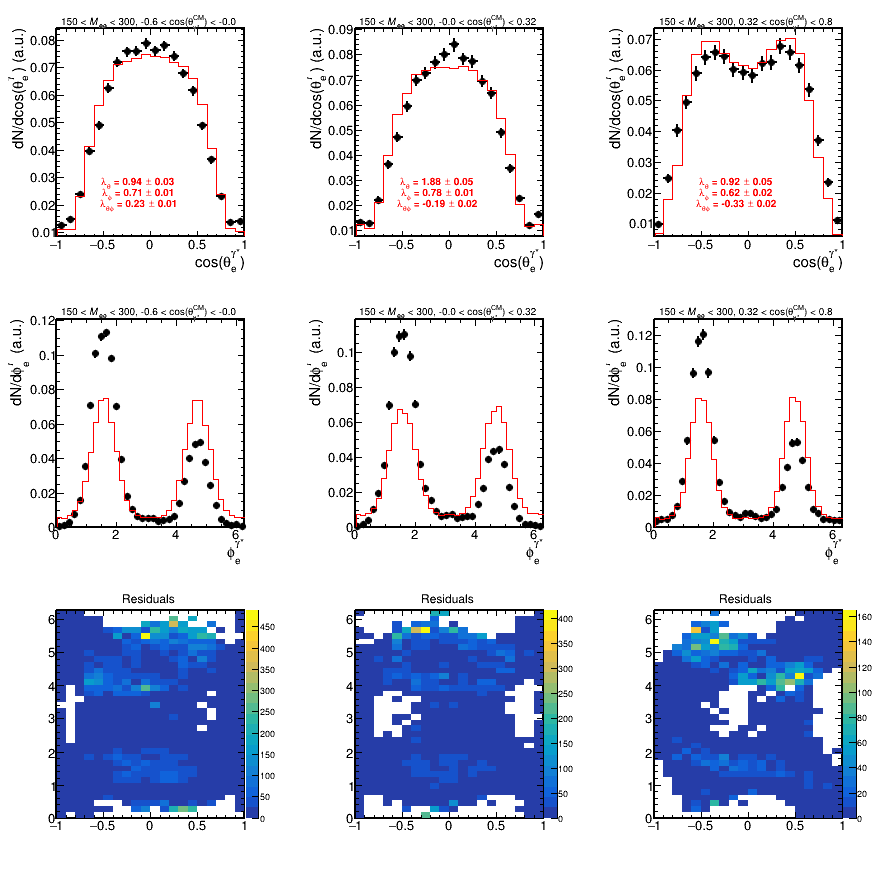

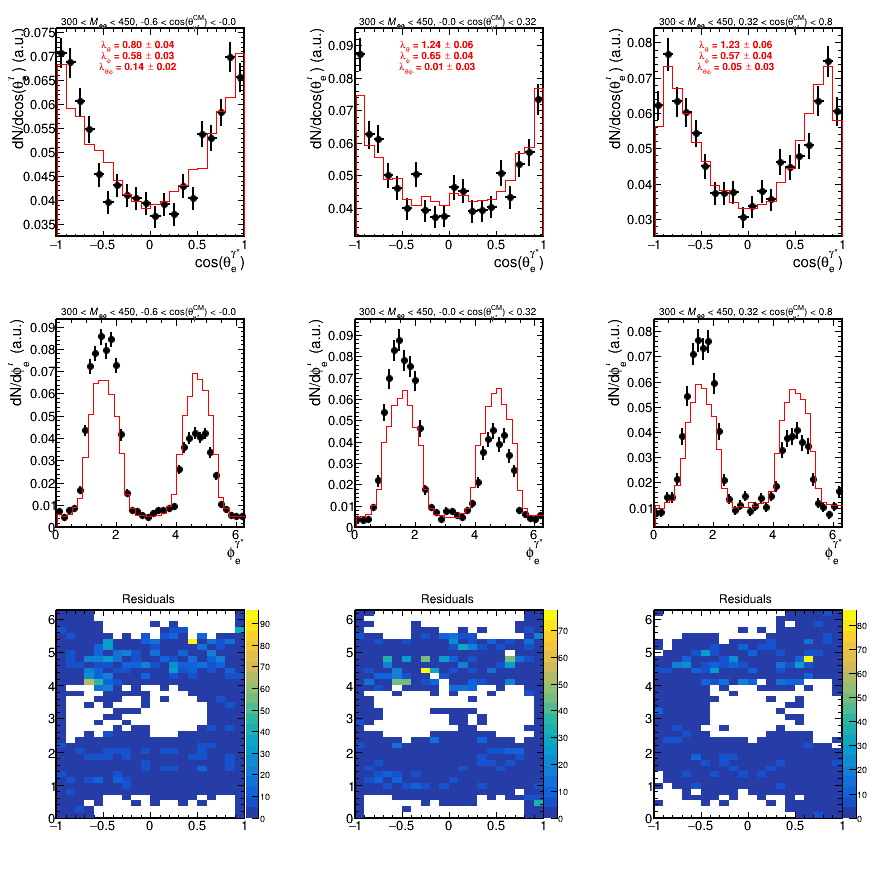

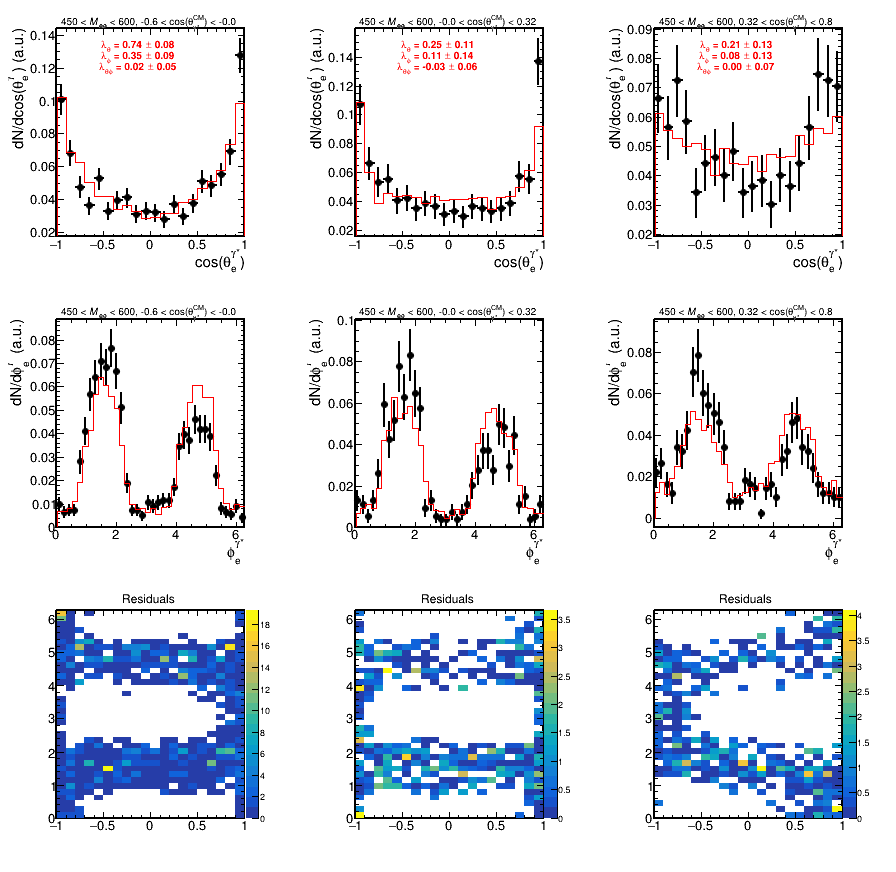

In [11]:
show_results("pp", DIR_NAME, range_used, parameters_all_pp, get_hist_maker_mc, bins, histsData_pp, analyse_3d)

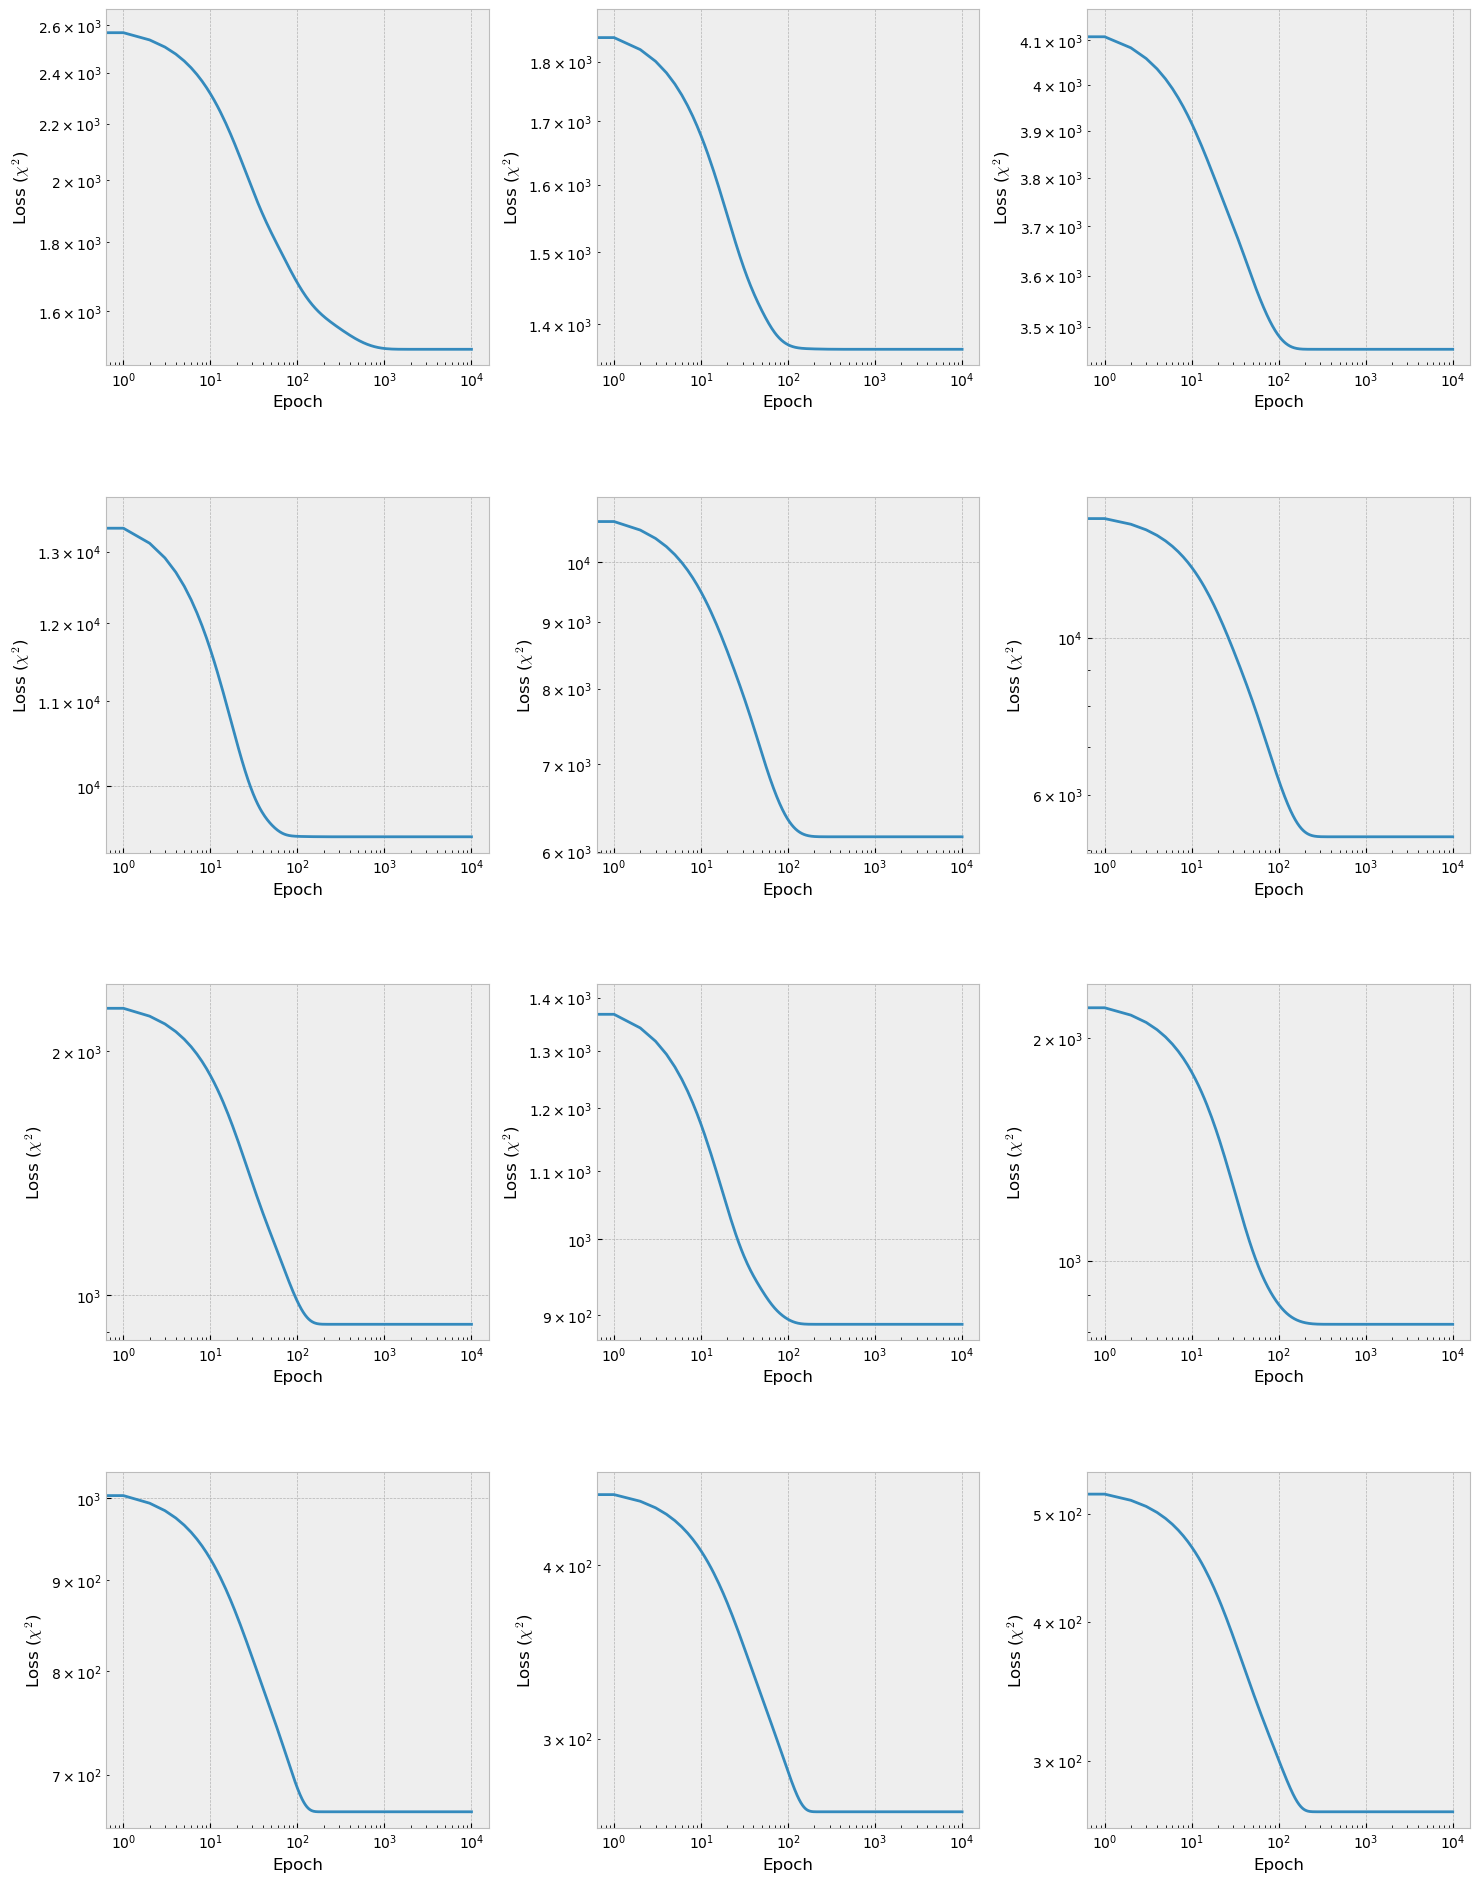

In [12]:
fig_nn, ax_nn = plot_losses(losses_all_nn, range_used)

Maybe covariance matrix:
tensor([[ 2.9024e-04, -1.9616e-03,  1.8644e-06,  6.7902e-05],
        [-1.9616e-03,  4.2630e-02,  2.4259e-03,  1.9081e-05],
        [ 1.8644e-06,  2.4259e-03,  3.1537e-03, -2.3572e-05],
        [ 6.7902e-05,  1.9081e-05, -2.3572e-05,  4.8472e-04]])
Compare:
Old: 0.3902063828277014, new: 0.2255069199886079, new/old: 0.5779170457295727
Old: 0.09535743069787285, new: 0.05618916171685876, new/old: 0.5892478573052847
Old: 0.07689739022850593, new: 0.025171926045121244, new/old: 0.3273443477122061
0. Final result: lambda_theta = 5.3230 +- 0.2255, lambda_phi = 0.7163 +- 0.0252, lambda_theta_phi = -0.1103 +- 0.0562
Maybe covariance matrix:
tensor([[ 3.1876e-04, -2.0444e-03, -1.3092e-05,  8.5524e-05],
        [-2.0444e-03,  3.4463e-02,  2.4677e-03, -6.7174e-04],
        [-1.3092e-05,  2.4677e-03,  2.6556e-03, -4.4824e-06],
        [ 8.5524e-05, -6.7174e-04, -4.4824e-06,  4.2449e-04]])
Compare:
Old: 0.7467668517525341, new: 0.18880245009846922, new/old: 0.252826500875584

Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_0
Info in <TCanvas::Print>: gif file results_1704048502/comparison_2.gif has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_3
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_3
Info in <TCanvas::Print>: gif file results_1704048502/comparison_5.gif has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_6
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_6
Info in <TCanvas::Print>: gif file results_1704048502/comparison_8.gif has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_9
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_9
Info in <TCanvas::Print>: gif file results_1704048502/comparison_11.gif has been created


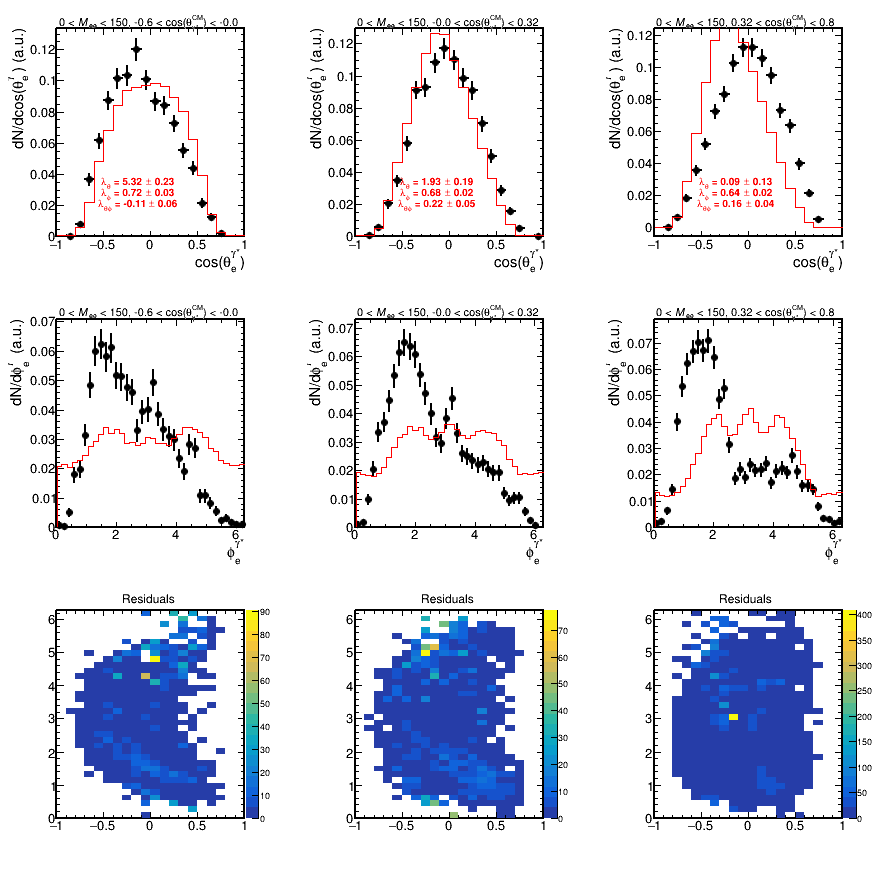

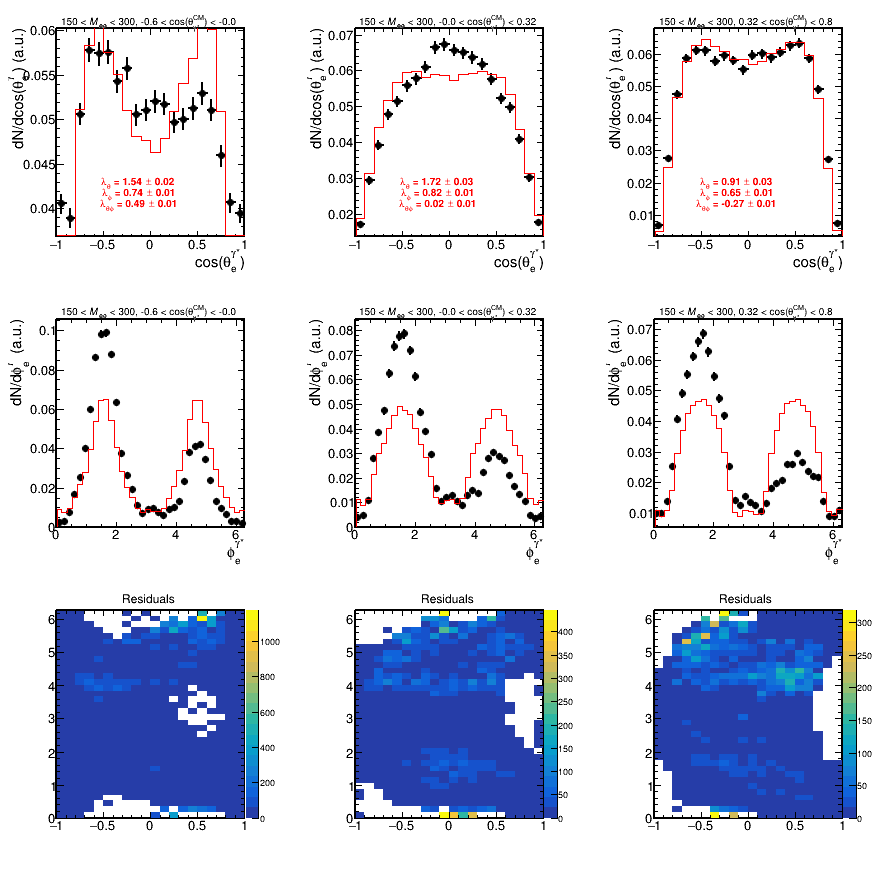

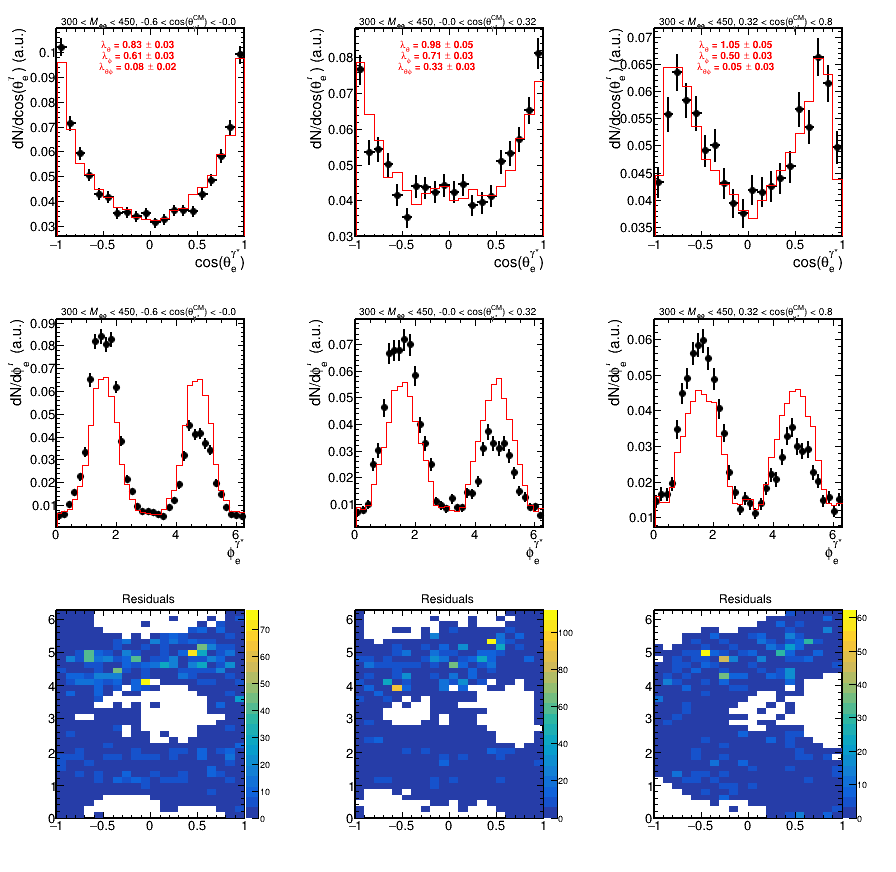

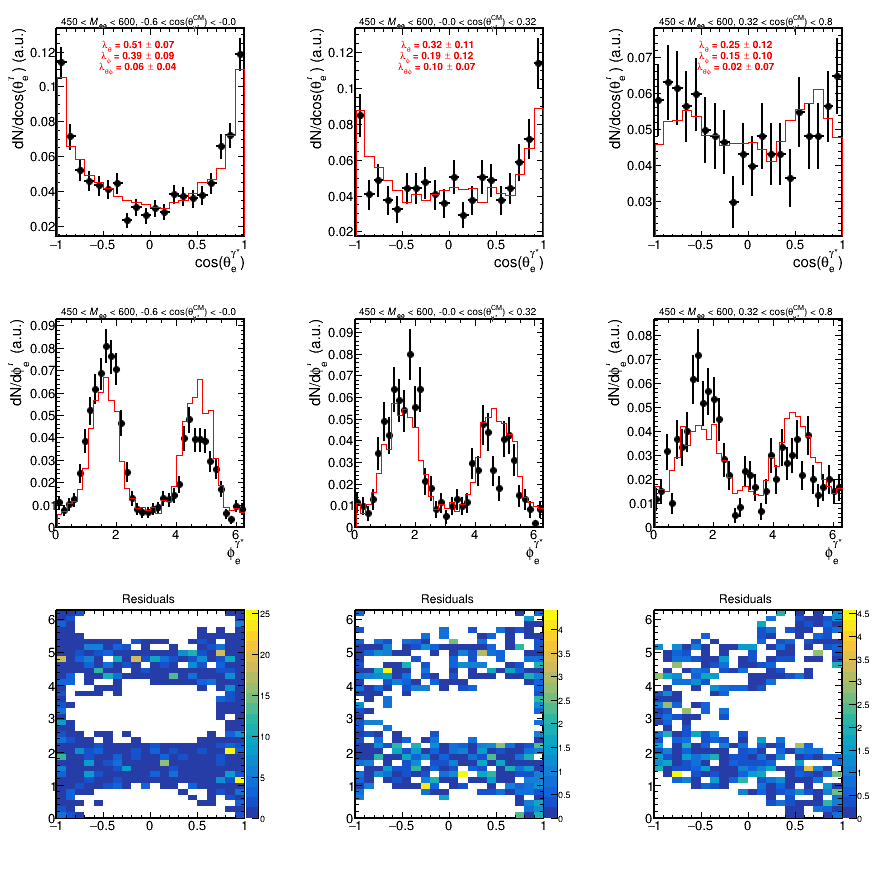

In [13]:
show_results("nn", DIR_NAME, range_used, parameters_all_nn, get_hist_maker_mc, bins, histsData_nn, analyse_3d)

In [14]:
if not analyse_3d:
    histsDataCorrs = []
    histsDatas = []
    histsModels = []
    hmodel_null = histMakerMC_rho_heli0_np.make_hists((0.0))
    hmodel_null_pp = histMakerMC_rho_heli0_pp.make_hists((0.0))
    hmodel_null_nn = histMakerMC_rho_heli0_nn.make_hists((0.0))
    hmodel_null_mix = histMakerMC_mix.make_hists((0.0))
    hmodel_null_pi0 = histMakerMC_pi0.make_hists((0.0))
    hmodel_null_heli1 = histMakerMC_rho_heli1.make_hists((0.0))

    pol2s = []
    histsAvg = []
    kfactors = []

    cc4 = TCanvas("cc4","cc4",900,1200)
    cc4.Divide(3,4)
    cc4.Draw()

    cck = TCanvas("cck","cck",900,1200)
    cck.Divide(3,4)

    csig = TCanvas("csig","csig",900,1200)
    csig.Divide(3,4)

    cacc = TCanvas("cacc","cacc",900,1200)
    cacc.Divide(3,4)

    for i, hist_np in enumerate(histsData_np[0]):
    
        if not isinstance(hist_np, list):

            hist_pp = histsData_pp[0][i]
            hist_nn = histsData_nn[0][i]
        
            if symmetrize_explicit:
                symmetrize(hist_np)
                symmetrize(hist_pp)
                symmetrize(hist_nn)
        
            histAvg = geom_avg1d(hist_pp, hist_nn, 0.2)
            histsAvg.append(histAvg)

        
            histCorr_np = hist_np.Clone(hist_np.GetName() + "_corr")
            histCorr_pp = hist_pp.Clone(hist_pp.GetName() + "_corr")
            histCorr_nn = hist_nn.Clone(hist_nn.GetName() + "_corr")
            histsDataCorrs.append(histCorr_np)
            histsDataCorrs.append(histCorr_pp)
            histsDataCorrs.append(histCorr_nn)
            histCorr_np.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
            pad = cc4.cd(i+1)
            set_pad(pad)       
       
            hist_kfactor = histsData_np_mix[0][i]
            hist_pp_mix = histsData_pp_mix[0][i]
            hist_nn_mix = histsData_nn_mix[0][i]

            if symmetrize_explicit:
                symmetrize(hist_kfactor)
                symmetrize(hist_pp_mix)
                symmetrize(hist_nn_mix)

            histAvg_mix = geom_avg1d(hist_pp_mix, hist_nn_mix, 0.2)
            hist_kfactor.Divide(histAvg_mix)
            hist_kfactor.Scale(2)
            kfactors.append(hist_kfactor)

            pad = cck.cd(i+1)
            set_pad(pad)

            hist_kfactor.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
            set_th1(hist_kfactor, histCorr_np.GetXaxis().GetTitle(), "#it{k}-factor", 
                   505, 20, 0.8, 1)
            hist_pp_mix.SetLineColor(2)
            hist_nn_mix.SetLineColor(4)
            hist_pp_mix.SetMarkerColor(2)
            hist_nn_mix.SetMarkerColor(4)
            hist_kfactor.Draw()
            hist_pp_mix.Draw("SAME")
            hist_nn_mix.Draw("SAME")
            hist_kfactor.SetMinimum(0)
             
            pad = cc4.cd(i+1)
            set_pad(pad)       
            
            histAvg_withK = histAvg.Clone(histAvg.GetName() + "_withK")
            histsAvg.append(histAvg_withK)
            histAvg_withK.Multiply(hist_kfactor)
            
            histAvg_withK.SetFillStyle(3004)
            histAvg_withK.SetFillColor(45)
            histAvg_withK.SetLineColor(45)
            histAvg.SetLineColor(6)
            hist_pp.SetLineColor(4)
            hist_nn.SetLineColor(2)
                    
            set_th1(hist_np, histCorr_np.GetXaxis().GetTitle(), f"dN/d{histCorr_np.GetXaxis().GetTitle()} (a.u.)", 
                   505, 20, 0.8, 1)
            hist_np.SetMinimum(0)
            hist_np.Draw()
            histAvg_withK.Draw("SAMEHIST")
            histAvg.Draw("SAMEHIST")
            hist_pp.Draw("SAMEHIST")
            hist_nn.Draw("SAMEHIST")
            
            pad = csig.cd(i+1)
            set_pad(pad)     
    
            hist_model_np = hmodel_null_mix[0][i]
            # TODO: make it consistent if we go the way of using mixing
            hist_model_pp = hmodel_null_mix[0][i]
            hist_model_nn = hmodel_null_mix[0][i]
            if not event_mixing:
                if i < 3:
                    hist_model_np = hmodel_null_pi0[0][i]
                    # TODO: make is consisnt if combinatorial background really matters for the pi0 region
                    hist_model_pp = hmodel_null_pi0[0][i]
                    hist_model_nn = hmodel_null_pi0[0][i]
                else:
                    hist_model_np = hmodel_null[0][i]
                    hist_model_pp = hmodel_null_pp[0][i]
                    hist_model_nn = hmodel_null_nn[0][i]
            if symmetrize_explicit:
                symmetrize(hist_model_np)
    
           # histCorr_np.Add(histAvg_withK,-1)
            histCorr_np.Divide(hist_model_np)
            histCorr_pp.Divide(hist_model_pp)
            histCorr_nn.Divide(hist_model_nn)
            
            histAvgCorr = geom_avg1d(histCorr_pp, histCorr_nn, 0.2)
            histsAvg.append(histAvgCorr)
            histAvgCorr_withK = histAvgCorr.Clone(histAvgCorr.GetName() + "_withK")
            histsAvg.append(histAvgCorr_withK)
            histAvgCorr_withK.Multiply(hist_kfactor)
        
            s2b = (hist_np.Integral() - histAvg_withK.Integral()) / histAvg_withK.Integral()
            s2b_corr = (histCorr_np.Integral() - histAvgCorr_withK.Integral()) / histAvgCorr_withK.Integral()
            histCorr_pp.Scale(s2b/s2b_corr)
            histCorr_nn.Scale(s2b/s2b_corr)
            histAvgCorr.Scale(s2b/s2b_corr)
            histAvgCorr_withK.Scale(s2b/s2b_corr)
        
            histAvgCorr_withK.SetFillStyle(3004)
            histAvgCorr_withK.SetFillColor(45)
            histAvgCorr_withK.SetLineColor(45)
            histAvgCorr.SetLineColor(6)
    
            #if symmetrize_explicit:    
                #symmetrize(histCorr_np)
    
            fit = TF1(f"fit_{i}", "[0]*(1+[1]*x*x)",-1.0,1.0)
            fit.SetParameters(1, 1)
            
            histCorr_np.Fit(fit,"Q")
            pol2s.append(fit)
        
            set_th1(histCorr_np, histCorr_np.GetXaxis().GetTitle(), f"dN/d{histCorr_np.GetXaxis().GetTitle()} (a.u.)", 
                   505, 20, 0.8, 1)
        
            histCorr_pp.SetLineColor(4)
            histCorr_nn.SetLineColor(2)
            histCorr_np.Draw()
            histCorr_pp.Draw("SAMEHIST")
            histCorr_nn.Draw("SAMEHIST")
            histAvgCorr.Draw("SAMEHIST")
            histAvgCorr_withK.Draw("SAMEHIST")
            if i < 3:
                # histCorr_np.GetYaxis().SetRangeUser(0,2.5)
                histCorr_np.GetYaxis().SetRangeUser(0,20)
            else:
                # histCorr_np.GetYaxis().SetRangeUser(0,1.25)    
                histCorr_np.GetYaxis().SetRangeUser(0,2)    
            histCorr_np.SetMinimum(0)
            
            caption = f"#lambda_{{#theta}} = {fit.GetParameter(1):.2f} #pm {fit.GetParError(1):.2f}"
            paveText = set_opt_text(caption, 0.25,0.76,0.675,0.88, 2, 0.04)
            paveTexts.append(paveText)
    
            pad = cacc.cd(i+1)
            set_pad(pad)
            
            hacc_heli0 = hmodel_null[0][i]
            hacc_heli1 = hmodel_null_heli1[0][i]
    
        else:
            print(hist_np)
    
    cc4.SaveAs(f"{DIR_NAME}/fit_classic.gif")
    cc4.SaveAs(f"{DIR_NAME}/fit_classic.pdf")
        


In [15]:
if not analyse_3d:
    cck.Draw()
    cck.SaveAs(f"{DIR_NAME}/kfactor.gif")
    
    csig.Draw()
    csig.SaveAs(f"{DIR_NAME}/signal.gif")

Info in <TCanvas::Print>: gif file results_1704048502/cmp_mass_z.gif has been created


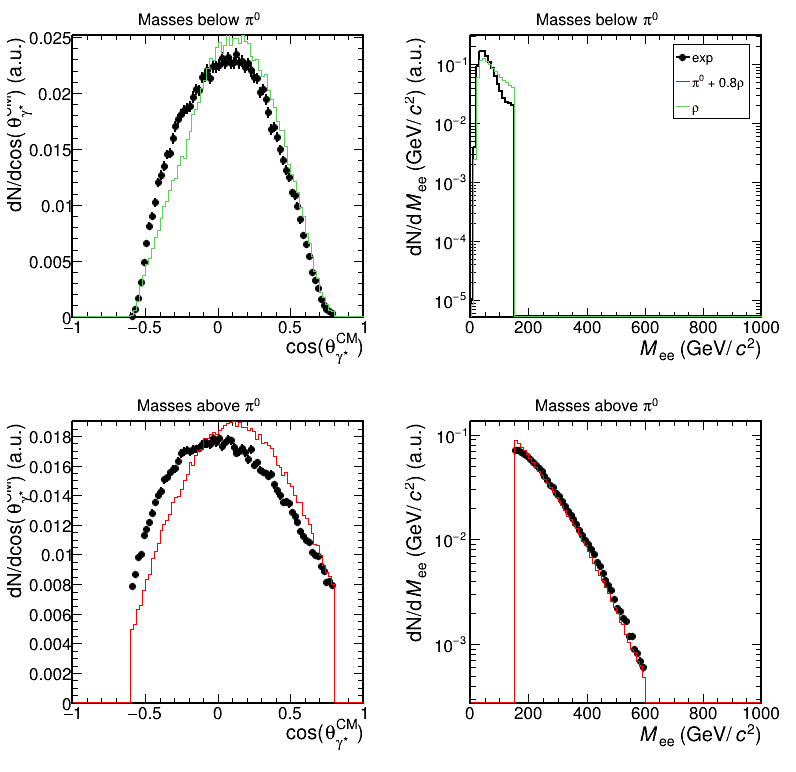

In [16]:
hmodelLowM_rho = histMakerMC_mix.make_hists(0.0) if event_mixing else histMakerMC_rho_heli0_np.make_hists(0.0)
hmodelLowM_rho[2][0].SetLineColor(8)
hmodelLowM_rho[1][0].SetLineColor(8)

hmodelLowM = histMakerMC_pi0.make_hists(0.0)

hmodelLowM[2][0].Scale(1.0/hmodelLowM[2][0].Integral())
hmodelLowM[1][0].Scale(1.0/hmodelLowM[1][0].Integral())
hmodelLowM_rho[2][0].Scale(1.0/hmodelLowM_rho[2][0].Integral())
hmodelLowM_rho[1][0].Scale(1.0/hmodelLowM_rho[1][0].Integral())

hmodelLowM[2][0].Add(hmodelLowM_rho[2][0], fraction)
hmodelLowM[1][0].Add(hmodelLowM_rho[1][0], fraction)

hmodelLowM[2][0].SetLineColor(2)
hmodelLowM[1][0].SetLineColor(2)
hmodelHigM = get_hist_maker_mc("np", 3).make_hists(0.0)
hmodelHigM[2][1].SetLineColor(2)
hmodelHigM[1][1].SetLineColor(2)

cc = TCanvas("cc","cc",800,800)
cc.Divide(2,2)
cc.Draw()

pad = cc.cd(1)
set_pad(pad)
dataScale = 1./histsData_np[2][0].Integral()
histsData_np[2][0].Scale(dataScale)
histsData_pp[2][0].Scale(dataScale)
histsData_nn[2][0].Scale(dataScale)
hmodelLowM[2][0].Scale(1./hmodelLowM[2][0].Integral())
hmodelLowM_rho[2][0].Scale(1./hmodelLowM_rho[2][0].Integral())
histsData_np[2][0].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][0].SetTitle("Masses below #pi^{0}")

set_th1(histsData_np[2][0], histsData_np[2][0].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[2][0].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[2][0].Draw()
#histsData_pp[2][0].Draw("SAME")
#histsData_nn[2][0].Draw("SAME")
hmodelLowM[2][0].Draw("SAMEHIST")
hmodelLowM_rho[2][0].Draw("SAMEHIST")

pad = cc.cd(2)
pad.SetLogy()
set_pad(pad)
histsData_np[1][0].Scale(1./histsData_np[1][0].Integral())
hmodelLowM[1][0].Scale(1./hmodelLowM[1][0].Integral())
hmodelLowM_rho[1][0].Scale(1./hmodelLowM_rho[1][0].Integral())
histsData_np[1][0].SetTitle("Masses below #pi^{0}")
histsData_np[1][0].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")

set_th1(histsData_np[1][0], histsData_np[1][0].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[1][0].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[1][0].Draw("HIST")
hmodelLowM[1][0].Draw("SAMEHIST")
hmodelLowM_rho[1][0].Draw("SAMEHIST")

legend = TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(histsData_np[1][0], "exp", "pl")
legend.AddEntry(hmodelLowM[1][0], f"#pi^{{0}} + {fraction}#rho", "l")
legend.AddEntry(hmodelLowM_rho[1][0], "#rho", "l")
legend.Draw()

pad = cc.cd(3)
set_pad(pad)
histsData_np[2][1].Scale(1./histsData_np[2][1].Integral())
hmodelHigM[2][1].Scale(1./hmodelHigM[2][1].Integral())
hmodelLowM_rho[2][1].Scale(1./hmodelLowM_rho[2][1].Integral())
histsData_np[2][1].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][1].SetTitle("Masses above #pi^{0}")

set_th1(histsData_np[2][1], histsData_np[2][1].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[2][1].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[2][1].Draw()
hmodelHigM[2][1].Draw("SAMEHIST")
#hmodelLowM_rho[2][1].Draw("SAMEHIST")

pad = cc.cd(4)
pad.SetLogy()
set_pad(pad)
histsData_np[1][1].Scale(1./histsData_np[1][1].Integral())
hmodelHigM[1][1].Scale(1./hmodelHigM[1][1].Integral())
hmodelLowM_rho[1][1].Scale(1./hmodelLowM_rho[1][1].Integral())
histsData_np[1][1].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")
histsData_np[1][1].SetTitle("Masses above #pi^{0}")

set_th1(histsData_np[1][1], histsData_np[1][1].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[1][1].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[1][1].Draw()
hmodelHigM[1][1].Draw("SAMEHIST")
#hmodelLowM_rho[1][1].Draw("SAMEHIST")

cc.SaveAs(f"{DIR_NAME}/cmp_mass_z.gif")

In [17]:
if not analyse_3d:
    cacc.Draw()
    cacc.SaveAs(f"{DIR_NAME}/cacc.gif")